In [20]:
import msoffcrypto
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import locale
from utils import calculate_age, drop_columns, average_fill_empty, calculate_malnutrition, drop_cap_nutrition_rows, generate_gender_column_and_carelevel, check_missing_values, fill_missing_by_idno_and_mode
from dotenv import load_dotenv
import os

# Reading an encrypted Excel file
encrypted_file_path = "./input/InterRAI Pt 4 2505.xlsx"
target_folder = "./input/"
# Use password in .env
load_dotenv()
# Reading an encrypted Excel file
# encrypted_file_path = os.getenv("CSV_PATH")
password = os.getenv("PASSWORD")


with open(encrypted_file_path, "rb") as f:
    office_file = msoffcrypto.OfficeFile(f)
    office_file.load_key(password=password)
    # Decrypt the file
    decrypted = io.BytesIO()
    office_file.decrypt(decrypted)

    dfs = pd.read_excel(decrypted, sheet_name=None, engine="openpyxl")
basic_info_df = dfs["Staying Upright InterRAI"]
extra_info_df = dfs["Staying Upright demo2"]

df = calculate_age(basic_info_df, extra_info_df)

    IDno        Age
0  01001  87.166667
1  01001  87.750000
2  01001  87.916667
3  01001  88.083333
4  01001  88.416667
5  01001  88.916667
6  01001  89.416667
7  01002  84.250000
8  01002  84.666667
9  01002  85.166667


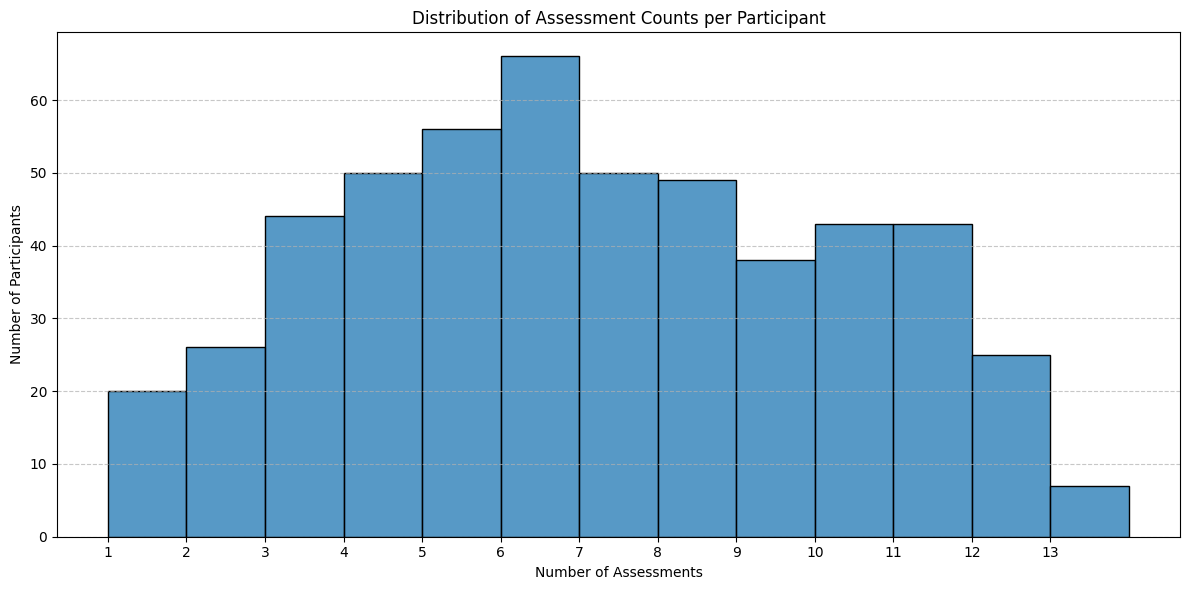

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 统计每个参与者的评估次数
participant_counts = df['IDno'].value_counts().reset_index()
participant_counts.columns = ['IDno', 'Assessment Count']

# 设置图形大小
plt.figure(figsize=(12, 6))

# 使用直方图展示评估次数的分布
sns.histplot(participant_counts['Assessment Count'], bins=range(1, participant_counts['Assessment Count'].max()+2), kde=False)

plt.title('Distribution of Assessment Counts per Participant')
plt.xlabel('Number of Assessments')
plt.ylabel('Number of Participants')
plt.xticks(range(1, participant_counts['Assessment Count'].max()+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# Display cap nutrition distribution table
import pandas as pd

def generate_cap_nutrition_distribution_table(df, id_col='IDno', target_col='CAP_Nutrition'):
    # Total assessments
    total_rows = len(df)

    # Count per CAP_Nutrition level
    count_table = df[target_col].value_counts().sort_index().to_dict()

    # Unique participant count per level
    participant_table = df.groupby(target_col)[id_col].nunique().to_dict()

    # Mapping CAP levels to description
    cap_mapping = {
        0: "No nutritional risk",
        1: "Moderate nutritional risk",
        2: "High nutritional risk"
    }

    # Build result table
    result = []
    for level in sorted(count_table.keys()):
        result.append({
            "CAP_Nutrition Level": level,
            "Description": cap_mapping.get(level, "Unknown"),
            "Assessment Count": count_table[level],
            "Percentage (%)": round(count_table[level] / total_rows * 100, 2),
            "Participant Count": participant_table.get(level, 0)
        })

    # Add total row
    result.append({
        "CAP_Nutrition Level": "Total",
        "Description": "",
        "Assessment Count": total_rows,
        "Percentage (%)": 100.0,
        "Participant Count": df[id_col].nunique()
    })

    # Convert to DataFrame
    result_df = pd.DataFrame(result)

    # Display result
    print("\nCAP_Nutrition Distribution Table:\n")
    print(result_df.to_string(index=False))

    return result_df


generate_cap_nutrition_distribution_table(basic_info_df)




CAP_Nutrition Distribution Table:

CAP_Nutrition Level               Description  Assessment Count  Percentage (%)  Participant Count
                0.0       No nutritional risk              2378           68.77                425
                1.0 Moderate nutritional risk               582           16.83                207
                2.0     High nutritional risk               432           12.49                169
              Total                                        3458          100.00                517


,CAP_Nutrition Level,Description,Assessment Count,Percentage (%),Participant Count
0,0.0,No nutritional risk,2378,68.77,425
1,1.0,Moderate nutritional risk,582,16.83,207
2,2.0,High nutritional risk,432,12.49,169
3,Total,,3458,100.00,517


In [12]:
# === Missing Value Summary ===
missing_summary = basic_info_df.isnull().sum().reset_index()
missing_summary.columns = ['Variable Name', 'Missing Count']
missing_summary['Missing Rate (%)'] = (missing_summary['Missing Count'] / len(basic_info_df) * 100).round(2)


# Show
print("\nMissing Value Summary:\n")
print(missing_summary.to_string(index=False))



Missing Value Summary:

            Variable Name  Missing Count  Missing Rate (%)
                     IDno              0              0.00
          Assessment_Date              0              0.00
                       A8             45              1.30
                  CAP_ADL              5              0.14
           CAP_Activities              5              0.14
            CAP_Behaviour              5              0.14
                CAP_Bowel              5              0.14
               CAP_Cardio              5              0.14
            CAP_Cognitive              5              0.14
        CAP_Communication              4              0.12
          CAP_Dehydration              5              0.14
             CAP_Delirium              4              0.12
                CAP_Falls              5              0.14
          CAP_FeedingTube              5              0.14
           CAP_Medication              5              0.14
                 CAP_Mood      

In [5]:
# Preprocess the DataFrames
df = calculate_age(basic_info_df, extra_info_df)
df = generate_gender_column_and_carelevel(basic_info_df, extra_info_df)
# # Check for missing values
# columns_to_check = ['iJ1g', 'iJ1h', 'iJ1i', 'iJ12', 'iK1ab', 'iK1bb']
# check_missing_values(columns_to_check, df)
df = drop_columns(df)

    IDno        Age
0  01001  87.166667
1  01001  87.750000
2  01001  87.916667
3  01001  88.083333
4  01001  88.416667
5  01001  88.916667
6  01001  89.416667
7  01002  84.250000
8  01002  84.666667
9  01002  85.166667
   CareLevel  Gender
0        1.0     2.0
1        3.0     2.0
2        3.0     1.0
3        3.0     1.0
4        3.0     1.0
5        1.0     2.0
6        3.0     1.0
7        1.0     2.0
8        1.0     2.0
9        3.0     2.0


In [6]:
# Generate cap df
cap_df = drop_cap_nutrition_rows(df)
cap_df = fill_missing_by_idno_and_mode(cap_df)
cap_df = calculate_malnutrition(cap_df)
cap_df.to_pickle(target_folder + 'cap_data.pkl')
# df = pd.read_pickle(target_folder + 'cap_data.pkl')

In [7]:
# Generate mal df
mal_df = fill_missing_by_idno_and_mode(df)
mal_df = calculate_malnutrition(df)
mal_df = mal_df.drop(columns=["iK2a", "iK2g", "iG3", "iE2a", "iE2b", "iE2c", "iI1c", "iI1d", "CAP_Nutrition"])
mal_df.to_pickle(target_folder + 'mal_data.pkl')
# mal_df = pd.read_pickle(target_folder + 'mal_data.pkl')

In [ ]:
import pickle
cap = pickle.load(open('./datasets/cap_data.pkl', 'rb'))


In [1]:
import pickle
mal = pickle.load(open('./datasets/MAL_1.pkl', 'rb'))


In [ ]:
import pickle
original = pickle.load(open('./datasets/original_data.pkl', 'rb'))


In [38]:
import pandas as pd
import numpy as np

# 假设 df 是你的原始数据
# CAP_Nutrition: 0, 1, 2
# Gender: 0=Female, 1=Male, 其他=Unknown
# Age: 连续变量

# 性别映射
gender_map = {
    2: "Female",
    1: "Male"
}

original['Gender_Label'] = original['Gender'].map(gender_map)
original['Gender_Label'] = original['Gender_Label'].fillna("Unknown")

# CAP_Nutrition 标签映射
cap_map = {
    0: "Not triggered",
    1: "Low risk",
    2: "High risk"
}
original['CAP_Label'] = original['CAP_Nutrition'].map(cap_map)

# ---- 1. 计算性别分布表 ----
gender_table = (
    original.groupby(['CAP_Label', 'Gender_Label'])
    .size()
    .unstack(fill_value=0)
    .T  # 转置，性别为行
)

# 添加百分比
gender_table_percent = gender_table.div(gender_table.sum(axis=0), axis=1) * 100
gender_table_combined = gender_table.astype(str) + " (" + gender_table_percent.round(2).astype(str) + "%)"

# ---- 2. 计算年龄均值 ± 标准差 ----
age_stats = original.groupby('CAP_Label')['Age'].agg(['mean', 'std'])
age_stats_formatted = age_stats.apply(lambda row: f"{row['mean']:.1f} ± {row['std']:.2f}", axis=1)

# ---- 3. 合并输出 ----
print("Gender Table:")
print(gender_table_combined)
print("\nAge Table:")
print(age_stats_formatted)


Gender Table:
CAP_Label        High risk      Low risk  Not triggered
Gender_Label                                           
Female        328 (75.93%)  423 (72.68%)  1432 (60.22%)
Male          104 (24.07%)  158 (27.15%)   945 (39.74%)
Unknown           0 (0.0%)     1 (0.17%)      1 (0.04%)

Age Table:
CAP_Label
High risk        85.4 ± 7.20
Low risk         86.5 ± 7.47
Not triggered    82.8 ± 7.79
dtype: object


In [ ]:
import pickle

# 打开并加载 mal_data.pkl
target_folder = "./datasets/"
with open(target_folder + "mal_data.pkl", "rb") as f:
    mal = pickle.load(f)

# 查看数据类型
print(type(data))
# 根据内容进一步查看
print(data)


<class 'pandas.core.frame.DataFrame'>
       IDno Assessment_Date  A8  CAP_ADL  CAP_Activities  CAP_Behaviour  \
0     01001       23JAN2017   2        0               0              0   
1     01001       29AUG2017   2        0               0              0   
2     01001       24OCT2017   4        0               1              0   
3     01001       28DEC2017   4        2               1              0   
4     01001       16APR2018   2        1               1              0   
...     ...             ...  ..      ...             ...            ...   
3453  26026       14AUG2020   2        1               0              0   
3454  26026       10FEB2021   2        0               0              0   
3455  26026       15FEB2021   2        0               0              0   
3456  26026       14AUG2021   2        0               0              0   
3457  26026       06FEB2022   2        0               0              0   

      CAP_Bowel  CAP_Cardio  CAP_Cognitive  CAP_Communication

TESTING GPU

In [1]:
import torch
import torch.nn as nn
import time

def test_gpu():
    print("PyTorch version:", torch.__version__)
    print("CUDA version:", torch.version.cuda)
    print("CUDA available:", torch.cuda.is_available())

    if not torch.cuda.is_available():
        print("❌ GPU 不可用，模型将只能使用 CPU。")
        return

    device = torch.device("cuda")
    print("✅ 当前 GPU 设备：", torch.cuda.get_device_name(0))

    # 构造一个简单的 LSTM 模型
    class SimpleLSTM(nn.Module):
        def __init__(self, input_size=32, hidden_size=64):
            super(SimpleLSTM, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, 3)

        def forward(self, x, lengths):
            packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, (ht, ct) = self.lstm(packed)
            out = self.fc(ht[-1])
            return out

    model = SimpleLSTM().to(device)

    # 生成模拟数据
    batch_size = 16
    seq_len = 10
    input_size = 32
    dummy_input = torch.randn(batch_size, seq_len, input_size).to(device)
    dummy_lengths = torch.tensor([seq_len]*batch_size).to(device)

    # 前向传播并计时
    start_time = time.time()
    with torch.no_grad():
        output = model(dummy_input, dummy_lengths)
    end_time = time.time()

    print("✅ 模型输出 device:", output.device)
    print("✅ 推理耗时: {:.6f} 秒".format(end_time - start_time))

    if str(output.device).startswith("cuda"):
        print("🎉 恭喜！模型已在 GPU 上成功运行。")
    else:
        print("⚠️ 模型没有在 GPU 上运行，可能有兼容性问题。")

if __name__ == "__main__":
    test_gpu()


PyTorch version: 2.5.1+cu121
CUDA version: 12.1
CUDA available: True
✅ 当前 GPU 设备： NVIDIA GeForce RTX 5070 Laptop GPU


f:\anaconda\envs\p4p\Lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5070 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5070 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [3]:
import pandas as pd
dataset_folder = "./datasets/"
cap_df = pd.read_pickle(dataset_folder + 'df.pkl')